# NLP - IS Newsletters

In this script the following pipeline is implemented

* read in PDF files via *pdfplumber* --> dataframe format
* pre-preprocess text --> list of lists of strings format
* **invert** the single words in order to make text readable
* preprocess text --> gensim formats
* estimate LDA
* visualize via *pyLDAvis*


### Specify File Path

In [1]:
# specify file path

file_path = 'read_pdfs'

### Import Packages

Be sure to have the necessary packages installed locally. Be sure to download NLTK stopword list by uncommenting and running the following cell.

In [2]:
#import nltk; nltk.download('stopwords')

In [3]:
#Generic
import os
from os.path import join
import matplotlib.pyplot as plt
%matplotlib inline
import re
import numpy as np
import pandas as pd
from pprint import pprint

#NLTK Stopword List
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('arabic')

#Gensim (LDA-Modelling)
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#PDF-Reader
import pdfplumber
import fitz

import pyLDAvis.gensim_models

### ToDo: Extend Stopword List

In [4]:
'''
stop_words.extend(
'example1',
'example2'
)
'''

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"\nstop_words.extend(\n'example1',\n'example2'\n)\n"

## Read PDFs

In [5]:
data_list = []
pages_list = []
file_list = []

for index, filename in enumerate(os.listdir(file_path)):
    if filename.endswith(".pdf"):
        with pdfplumber.open(join(file_path,filename)) as stream_pdf:
            pages_content = [i.extract_text() for i in stream_pdf.pages]
            number_pages = len(pages_content)
            data_list.extend(pages_content)
            pages_list.extend(i+1 for i in range(number_pages))
            file_list.extend([filename] * number_pages)
            
data_df = pd.DataFrame({'content': data_list,
                        'page': pages_list,
                        'file': file_list,
                        'date': np.nan})

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
data_df#.head()

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,page,file,date
0,ـه 1440 ىلولأا ىدامج 25 سيمخلا ا ةرشاعلا ةنسلا...,1,the-islamic-state-22al-nabacc84e28099-newslett...,NaN
1,None,2,the-islamic-state-22al-nabacc84e28099-newslett...,NaN
2,3\nةيحاتتفلاا\n167 ددعلا\nـه 1440 ىلولأا ىدامج...,3,the-islamic-state-22al-nabacc84e28099-newslett...,NaN
3,4\n167 ددعلا راــبخأ\nـه 1440 ىلولأا ىدامج 25 ...,4,the-islamic-state-22al-nabacc84e28099-newslett...,NaN
4,5\nراــبخأ 167 ددعلا\nـه 1440 ىلولأا ىدامج 25 ...,5,the-islamic-state-22al-nabacc84e28099-newslett...,NaN
...,...,...,...,...
87,12\nـه 1437/9/16 | نوثلاثلاو سداسلا ددعلا\nدي...,12,the-islamic-state-22al-nabacc84_-newsletter-36...,NaN
88,13\nـه 1437/9/16 | نوثلاثلاو سداسلا ددعلا\nتل...,13,the-islamic-state-22al-nabacc84_-newsletter-36...,NaN
89,14\nـه 1437/9/16 | نوثلاثلاو سداسلا ددعلا\nتت...,14,the-islamic-state-22al-nabacc84_-newsletter-36...,NaN
90,15\nـه 1437/9/16 | نوثلاثلاو سداسلا ددعلا\nتا...,15,the-islamic-state-22al-nabacc84_-newsletter-36...,NaN


In [35]:
data_df['content'][0]

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'ـه 1440 ىلولأا ىدامج 25 سيمخلا ا ةرشاعلا ةنسلا ا 167 ددعلا\nةحفص 12\n نيبراحملا ىراصنلا نم اً باصمو اً كلاه 120\nةسينك ىلع جودزم يداهشتسا موجهب\n ايبرح  ايناصرن  120  وحن  طقس\n جودزم  يداهشتسا  موجهب\n ىراصنلا  سئانك  ىدحإ  فدهتسا 167 ددعلا\n ءادلأ  مهعمجت  ءانثأ  ينبلفلا  في\n ناوــيد نع ردصت ةيعوبسأ ةفيحص\n وحن طقس امنيب ،ةيكشرلا مهسوقط\n حيرجو ليتق ينب ايبيلص ايدنح 50 يزـكرملا ملاـعلإا\n رثإ  ةيملاسلإا  ةلودلا  دونج  دي  لىع\n للاخ  مهنيب  تراد  يتلا  تاهجاولما\n.لياحلا عوبسلأا  ـلا نم اًباصمو اًكلاه 14\n نم  ناسراف  قلطنا  ،لايصفتو PKK\nنيدترملا \n /21(  دحلأا  ةداهشلا  ناسرف\n ىراصنلل دبعم وحن )لىولأا ىدامج  ةلودلا دونج تايلمعب\n ريزج  في  )ولوه(  ةنيدمب  ينبراحلما ريخلا يف ةيملاسلإا\n امهيمازحب  ينمزحتم  ،وانادنيم\n همازح  لولأا  رجّ ف  ثيح  ،ينفسانلا 4\n مهعمجت  ءانثأ  دبعلما  ةباوب  دنع\n... مهسوقط ءادلأ  ىلتقلا نم ديدعلا\nPKK\n ـلل ىحرجلاو\n نيموجهب\n 50 وحن طوقس\n ىلع نييداهشتسا\nاً ينيبلف اً يدنج\nزوغابلا يف مهتاعمجت\n6 6\nريراقت صاــــــخ\n نم نيرصنع لتق\n ريمدتو تاوحصلا\

In [7]:
def get_text(filepath):
    data_list = []
    pages_list = []
    file_list = []
    for filename in os.listdir(file_path):
        if filename.endswith(".pdf"):
            with fitz.open(join(file_path,filename)) as doc:
                pages_content = [page.getText() for page in doc]
                number_pages = len(pages_content)
                data_list.extend(pages_content)
                pages_list.extend(i+1 for i in range(number_pages))
                file_list.extend([filename] * number_pages)

    data_df_mu = pd.DataFrame({'content': data_list,
                        'page': pages_list,
                        'file': file_list,
                        'date': np.nan})
    return data_df_mu

#get_text(file_path)
data_df_mu = get_text(file_path)

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
data_df_mu

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,page,file,date
0,50 وحن طوقس\nًاينيبلف ًايدنج\n عوبسلأا للاخ ن...,1,the-islamic-state-22al-nabacc84e28099-newslett...,NaN
1,,2,the-islamic-state-22al-nabacc84e28099-newslett...,NaN
2,167 ددعلا\nـه 1440 ىلولأا ىدامج 25 سيمخلاةيحات...,3,the-islamic-state-22al-nabacc84e28099-newslett...,NaN
3,167 ددعلا\nـه 1440 ىلولأا ىدامج 25 سيمخلا4راــ...,4,the-islamic-state-22al-nabacc84e28099-newslett...,NaN
4,167 ددعلا\nـه 1440 ىلولأا ىدامج 25 سيمخلاراــب...,5,the-islamic-state-22al-nabacc84e28099-newslett...,NaN
...,...,...,...,...
87,12\nـه 1437/9/16 | نوثلاثلاو سداسلا ددعلا\n ذ...,12,the-islamic-state-22al-nabacc84_-newsletter-36...,NaN
88,13\nـه 1437/9/16 | نوثلاثلاو سداسلا ددعلاتلاا...,13,the-islamic-state-22al-nabacc84_-newsletter-36...,NaN
89,14\nـه 1437/9/16 | نوثلاثلاو سداسلا ددعلاتلاا...,14,the-islamic-state-22al-nabacc84_-newsletter-36...,NaN
90,15\nـه 1437/9/16 | نوثلاثلاو سداسلا ددعلاتاعب...,15,the-islamic-state-22al-nabacc84_-newsletter-36...,NaN


In [32]:
data_df_mu['content'][0]

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


' 50 وحن طوقس\nًاينيبلف ًايدنج\n عوبسلأا للاخ نودهاجلما لاتغا\n توصلل ةمتاكلا ةحلسلأاب لياحلا\nـلا صرانع نم 3 ةقرلا ةنيدم في\n لمعي ققحم مهنيب ،نيدترلما PKK\n ةفاضإ ،تارابختسلاا زاهج ىدل\n ازجاح ةفلاخلا دونج فادهتسا لىإ\n ،)سوحلا( ةيرق في نيدترملل\n .مهل ةيلآ لىع ةفسان ةوبع يرجفتو\n ىدامج /20( تبسلا موي يفف\n ةلودلا دونج لاتغا )لىولأا\n PKKـلا نم اصرنع ةيملاسلإا\n دنع ةيدرفلا مهتحلسأ نايرنب\n لىع هكلاهل ىدأ ام ،ةرزجلا قرفم\n.ةنلماو دمحلا هللو ،روفلا\n ىدامج /23( ءاثلاثلا موي فيو\n ةلودلا دونج دحأ نّكمت )لىولأا\nـلا نم صرنع لايتغا نم ةيملاسلإا\n توصلل متاك حلاسب نيدترلما PKK\n عراشب )لافطلأا ىفشم( برق\n لىع هكلاهل ىدأ ام ،ةقرلا في رونلا\n.روفلا\n... في مهيرجفت لىإ ةفاضإ\n نم 2و تارابختسلاا زاهج ىدل ققحم لايتغا\nةقرلا يف PKK ـلا رصانع\n5 ص ليصافتلا\n دونج تايلمعب\nىلايد يف ةفلاخلا\n نم نيرصنع لتق\n ريمدتو تاوحصلا\n ةرايس باطعإو\n نيتفارجو\n ىلتقلا نم ديدعلا\nPKK ـلل ىحرجلاو\n ةلودلا دونج تايلمعب\nريخلا يف ةيملاسلإا\nدترملا يرصملا شيجلل\n نيموجهب\n ىلع نييداهشتسا\nزوغابلا يف مهتاعمجت\n ـل

In [9]:
data_df = data_df.dropna(subset=['content'])
data_df_mu = data_df_mu.dropna(subset=['content'])

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Preprocessing - Remove Special Signs, Numbers, etc.

In [10]:
def preproc(data_df):
    # Convert to list
    data = data_df['content'].values.tolist()

    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]
    data = [re.sub('\n', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]

    # Remove Numbers
    for i in range(10):
        data = [re.sub(str(i), "", sent) for sent in data]

    # block does not work
    # Remove Brackets
    ''' 
    data = [re.sub("\[", "", sent) for sent in data]
    data = [re.sub("\]", "", sent) for sent in data]
    data = [re.sub("\(", "", sent) for sent in data]
    data = [re.sub("\)", "", sent) for sent in data]
    data = [re.sub("|", "", sent) for sent in data]
    data = [re.sub("/", "", sent) for sent in data]
    '''

    return data

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:6: DeprecationWarning: invalid escape sequence \S
<>:9: DeprecationWarning: invalid escape sequence \s
<>:21: DeprecationWarning: invalid escape sequence \[
<>:6: DeprecationWarning: invalid escape sequence \S
<>:9: DeprecationWarning: invalid escape sequence \s
<>:21: DeprecationWarning: invalid escape sequence \[
<ipython-input-10-a6b8eeb0530c>:6: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
<ipython-input-10-a6b8eeb0530c>:9: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]
<ipython-input-10-a6b8eeb0530c>:2

In [11]:
data = preproc(data_df)
data_mu = preproc(data_df_mu)

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Preprocessing - gensim procedure (phrasing, stopwords)

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
data_words_mu = list(sent_to_words(data_mu))


print(data_words[:1])

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[['ـه', 'ىلولاا', 'ىدامج', 'سيمخلا', 'ةرشاعلا', 'ةنسلا', 'ددعلا', 'ةحفص', 'نيبراحملا', 'ىراصنلا', 'نم', 'باصمو', 'كلاه', 'ةسينك', 'ىلع', 'جودزم', 'يداهشتسا', 'موجهب', 'ايبرح', 'ايناصرن', 'وحن', 'طقس', 'جودزم', 'يداهشتسا', 'موجهب', 'ىراصنلا', 'سيانك', 'ىدحا', 'فدهتسا', 'ددعلا', 'ءادلا', 'مهعمجت', 'ءانثا', 'ينبلفلا', 'في', 'ناوــيد', 'نع', 'ردصت', 'ةيعوبسا', 'ةفيحص', 'وحن', 'طقس', 'امنيب', 'ةيكشرلا', 'مهسوقط', 'حيرجو', 'ليتق', 'ينب', 'ايبيلص', 'ايدنح', 'يزـكرملا', 'ملاـعلاا', 'رثا', 'ةيملاسلاا', 'ةلودلا', 'دونج', 'دي', 'لىع', 'للاخ', 'مهنيب', 'تراد', 'يتلا', 'تاهجاولما', 'لياحلا', 'عوبسلاا', 'ـلا', 'نم', 'اباصمو', 'اكلاه', 

In [13]:
print(data_words_mu[:1])

[['وحن', 'طوقس', 'اينيبلف', 'ايدنج', 'عوبسلاا', 'للاخ', 'نودهاجلما', 'لاتغا', 'توصلل', 'ةمتاكلا', 'ةحلسلااب', 'لياحلا', 'ـلا', 'صرانع', 'نم', 'ةقرلا', 'ةنيدم', 'في', 'لمعي', 'ققحم', 'مهنيب', 'نيدترلما', 'pkk', 'ةفاضا', 'تارابختسلاا', 'زاهج', 'ىدل', 'ازجاح', 'ةفلاخلا', 'دونج', 'فادهتسا', 'لىا', 'سوحلا', 'ةيرق', 'في', 'نيدترملل', 'مهل', 'ةيلا', 'لىع', 'ةفسان', 'ةوبع', 'يرجفتو', 'ىدامج', 'تبسلا', 'موي', 'يفف', 'ةلودلا', 'دونج', 'لاتغا', 'لىولاا', 'pkkـلا', 'نم', 'اصرنع', 'ةيملاسلاا', 'دنع', 'ةيدرفلا', 'مهتحلسا', 'نايرنب', 'لىع', 'هكلاهل', 'ىدا', 'ام', 'ةرزجلا', 'قرفم', 'ةنلماو', 'دمحلا', 'هللو', 'روفلا', 'ىدامج', 'ءاثلاثلا', 'موي', 'فيو', 'ةلودلا', 'دونج', 'دحا', 'نكمت', 'لىولاا', 'ـلا', 'نم', 'صرنع', 'لايتغا', 'نم', 'ةيملاسلاا', 'توصلل', 'متاك', 'حلاسب', 'نيدترلما', 'pkk', 'عراشب', 'لافطلاا', 'ىفشم', 'برق', 'لىع', 'هكلاهل', 'ىدا', 'ام', 'ةقرلا', 'في', 'رونلا', 'روفلا', 'في', 'مهيرجفت', 'لىا', 'ةفاضا', 'نم', 'تارابختسلاا', 'زاهج', 'ىدل', 'ققحم', 'لايتغا', 'ةقرلا', 'يف', 'pkk', 'ـلا', 'رصا

In [14]:
def grammization(data_words):
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    return bigram, trigram, bigram_mod, trigram_mod

# apply fct above
bigram, trigram, bigram_mod, trigram_mod = grammization(data_words)
bigram_mu, trigram_mu, bigram_mod_mu, trigram_mod_mu = grammization(data_words_mu)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
['ـه_ىلولاا_ىدامج_سيمخلا', 'ةرشاعلا', 'ةنسلا', 'ددعلا', 'ةحفص', 'نيبراحملا', 'ىراصنلا', 'نم', 'باصمو', 'كلاه', 'ةسينك', 'ىلع', 'جودزم', 'يداهشتسا_موجهب', 'ايبرح', 'ايناصرن', 'وحن', 'طقس', 'جودزم', 'يداهشتسا_موجهب', 'ىراصنلا', 'سيانك', 'ىدحا', 'فدهتسا', 'ددعلا', 'ءادلا', 'مهعمجت', 'ءانثا', 'ينبلفلا', 'في', 'ناوــيد', 'نع', 'ردصت', 'ةيعوبسا_ةفيحص', 'وحن', 'طقس', 'امنيب', 'ةيكشرلا', 'مهسوقط', 'حيرجو_ليتق_ينب', 'ايبيلص', 'ايدنح', 'يزـكرملا', 'ملاـعلاا', 'رثا', 'ةيملاسلاا_ةلودلا_دونج', 'دي', 'لىع', 'للاخ', 'مهنيب', 'تراد', 'يتلا', 'تاهجاولما', 'لياحلا_عوبسلاا', 'ـلا', 'نم', 'اباصمو', 'اكلاه', 'نم', 'ناسراف', 'قلطنا', 'لايصفتو'

In [15]:
print(trigram_mod[bigram_mod[data_words_mu[0]]])

['وحن', 'طوقس', 'اينيبلف', 'ايدنج', 'عوبسلاا_للاخ', 'نودهاجلما', 'لاتغا', 'توصلل', 'ةمتاكلا', 'ةحلسلااب', 'لياحلا', 'ـلا', 'صرانع', 'نم', 'ةقرلا', 'ةنيدم', 'في', 'لمعي', 'ققحم', 'مهنيب', 'نيدترلما', 'pkk', 'ةفاضا', 'تارابختسلاا', 'زاهج', 'ىدل', 'ازجاح', 'ةفلاخلا', 'دونج', 'فادهتسا', 'لىا', 'سوحلا', 'ةيرق', 'في', 'نيدترملل', 'مهل', 'ةيلا', 'لىع', 'ةفسان_ةوبع', 'يرجفتو', 'ىدامج', 'تبسلا_موي', 'يفف', 'ةلودلا', 'دونج', 'لاتغا', 'لىولاا', 'pkkـلا', 'نم', 'اصرنع', 'ةيملاسلاا', 'دنع', 'ةيدرفلا', 'مهتحلسا_نايرنب', 'لىع', 'هكلاهل_ىدا', 'ام', 'ةرزجلا', 'قرفم', 'ةنلماو_دمحلا_هللو', 'روفلا', 'ىدامج', 'ءاثلاثلا', 'موي', 'فيو', 'ةلودلا', 'دونج', 'دحا', 'نكمت', 'لىولاا', 'ـلا', 'نم', 'صرنع', 'لايتغا', 'نم', 'ةيملاسلاا', 'توصلل', 'متاك', 'حلاسب', 'نيدترلما', 'pkk', 'عراشب', 'لافطلاا', 'ىفشم', 'برق', 'لىع', 'هكلاهل_ىدا', 'ام', 'ةقرلا', 'في', 'رونلا', 'روفلا', 'في', 'مهيرجفت', 'لىا', 'ةفاضا', 'نم', 'تارابختسلاا', 'زاهج', 'ىدل', 'ققحم', 'لايتغا', 'ةقرلا', 'يف', 'pkk_ـلا', 'رصانع', 'ليصافتلا', 'دونج', 'تا

In [16]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

'''
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
'''

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'\ndef lemmatization(texts, allowed_postags=[\'NOUN\', \'ADJ\', \'VERB\', \'ADV\']):\n    """https://spacy.io/api/annotation"""\n    texts_out = []\n    for sent in texts:\n        doc = nlp(" ".join(sent)) \n        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])\n    return texts_out\n'

In [17]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
data_words_nostops_mu = remove_stopwords(data_words_mu)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
data_words_bigrams_mu = make_bigrams(data_words_nostops_mu)


# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = spacy.load("en_core_web_sm")

# Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_words_nostops[:1])

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[['ـه', 'ىلولاا', 'ىدامج', 'سيمخلا', 'ةرشاعلا', 'ةنسلا', 'ددعلا', 'ةحفص', 'نيبراحملا', 'ىراصنلا', 'نم', 'باصمو', 'كلاه', 'ةسينك', 'ىلع', 'جودزم', 'يداهشتسا', 'موجهب', 'ايبرح', 'ايناصرن', 'وحن', 'طقس', 'جودزم', 'يداهشتسا', 'موجهب', 'ىراصنلا', 'سيانك', 'ىدحا', 'فدهتسا', 'ددعلا', 'ءادلا', 'مهعمجت', 'ءانثا', 'ينبلفلا', 'ناوــيد', 'نع', 'ردصت', 'ةيعوبسا', 'ةفيحص', 'وحن', 'طقس', 'امنيب', 'ةيكشرلا', 'مهسوقط', 'حيرجو', 'ليتق', 'ينب', 'ايبيلص', 'ايدنح', 'يزـكرملا', 'ملاـعلاا', 'رثا', 'ةيملاسلاا', 'ةلودلا', 'دونج', 'دي', 'لىع', 'للاخ', 'مهنيب', 'تراد', 'يتلا', 'تاهجاولما', 'لياحلا', 'عوبسلاا', 'ـلا', 'نم', 'اباصمو', 'اكلاه', 'نم', 

In [18]:
print(data_words_nostops_mu[:1])

[['وحن', 'طوقس', 'اينيبلف', 'ايدنج', 'عوبسلاا', 'للاخ', 'نودهاجلما', 'لاتغا', 'توصلل', 'ةمتاكلا', 'ةحلسلااب', 'لياحلا', 'ـلا', 'صرانع', 'نم', 'ةقرلا', 'ةنيدم', 'لمعي', 'ققحم', 'مهنيب', 'نيدترلما', 'pkk', 'ةفاضا', 'تارابختسلاا', 'زاهج', 'ىدل', 'ازجاح', 'ةفلاخلا', 'دونج', 'فادهتسا', 'لىا', 'سوحلا', 'ةيرق', 'نيدترملل', 'مهل', 'ةيلا', 'لىع', 'ةفسان', 'ةوبع', 'يرجفتو', 'ىدامج', 'تبسلا', 'موي', 'يفف', 'ةلودلا', 'دونج', 'لاتغا', 'لىولاا', 'pkkـلا', 'نم', 'اصرنع', 'ةيملاسلاا', 'دنع', 'ةيدرفلا', 'مهتحلسا', 'نايرنب', 'لىع', 'هكلاهل', 'ىدا', 'ام', 'ةرزجلا', 'قرفم', 'ةنلماو', 'دمحلا', 'هللو', 'روفلا', 'ىدامج', 'ءاثلاثلا', 'موي', 'فيو', 'ةلودلا', 'دونج', 'دحا', 'نكمت', 'لىولاا', 'ـلا', 'نم', 'صرنع', 'لايتغا', 'نم', 'ةيملاسلاا', 'توصلل', 'متاك', 'حلاسب', 'نيدترلما', 'pkk', 'عراشب', 'لافطلاا', 'ىفشم', 'برق', 'لىع', 'هكلاهل', 'ىدا', 'ام', 'ةقرلا', 'رونلا', 'روفلا', 'مهيرجفت', 'لىا', 'ةفاضا', 'نم', 'تارابختسلاا', 'زاهج', 'ىدل', 'ققحم', 'لايتغا', 'ةقرلا', 'يف', 'pkk', 'ـلا', 'رصانع', 'ليصافتلا', 'دونج',

### Extra Step: invert single words

In [19]:
def invert_words(data_words_nostops):
    data_words_nostops_inverted = []
    for i in data_words_nostops:
        temp = [j[::-1] for j in i]
        data_words_nostops_inverted.append(temp)
    return data_words_nostops_inverted

data_words_nostops_inverted = invert_words(data_words_nostops)
data_words_nostops_inverted_mu = invert_words(data_words_nostops_mu)

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
data_words_nostops_inverted_mu[0]

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['نحو',
 'سقوط',
 'فلبينيا',
 'جنديا',
 'االسبوع',
 'خالل',
 'املجاهدون',
 'اغتال',
 'للصوت',
 'الكاتمة',
 'باالسلحة',
 'الحايل',
 'الـ',
 'عنارص',
 'من',
 'الرقة',
 'مدينة',
 'يعمل',
 'محقق',
 'بينهم',
 'املرتدين',
 'kkp',
 'اضافة',
 'االستخبارات',
 'جهاز',
 'لدى',
 'حاجزا',
 'الخالفة',
 'جنود',
 'استهداف',
 'اىل',
 'الحوس',
 'قرية',
 'للمرتدين',
 'لهم',
 'الية',
 'عىل',
 'ناسفة',
 'عبوة',
 'وتفجري',
 'جمادى',
 'السبت',
 'يوم',
 'ففي',
 'الدولة',
 'جنود',
 'اغتال',
 'االوىل',
 'الـkkp',
 'من',
 'عنرصا',
 'االسالمية',
 'عند',
 'الفردية',
 'اسلحتهم',
 'بنريان',
 'عىل',
 'لهالكه',
 'ادى',
 'ما',
 'الجزرة',
 'مفرق',
 'واملنة',
 'الحمد',
 'ولله',
 'الفور',
 'جمادى',
 'الثالثاء',
 'يوم',
 'ويف',
 'الدولة',
 'جنود',
 'احد',
 'تمكن',
 'االوىل',
 'الـ',
 'من',
 'عنرص',
 'اغتيال',
 'من',
 'االسالمية',
 'للصوت',
 'كاتم',
 'بسالح',
 'املرتدين',
 'kkp',
 'بشارع',
 'االطفال',
 'مشفى',
 'قرب',
 'عىل',
 'لهالكه',
 'ادى',
 'ما',
 'الرقة',
 'النور',
 'الفور',
 'تفجريهم',
 'اىل',
 'اضافة',
 'من',
 'االس

In [33]:
data_words_nostops_inverted[0]

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['هـ',
 'االولى',
 'جمادى',
 'الخميس',
 'العاشرة',
 'السنة',
 'العدد',
 'صفحة',
 'المحاربين',
 'النصارى',
 'من',
 'ومصاب',
 'هالك',
 'كنيسة',
 'على',
 'مزدوج',
 'استشهادي',
 'بهجوم',
 'حربيا',
 'نرصانيا',
 'نحو',
 'سقط',
 'مزدوج',
 'استشهادي',
 'بهجوم',
 'النصارى',
 'كنايس',
 'احدى',
 'استهدف',
 'العدد',
 'الداء',
 'تجمعهم',
 'اثناء',
 'الفلبني',
 'ديــوان',
 'عن',
 'تصدر',
 'اسبوعية',
 'صحيفة',
 'نحو',
 'سقط',
 'بينما',
 'الرشكية',
 'طقوسهم',
 'وجريح',
 'قتيل',
 'بني',
 'صليبيا',
 'حنديا',
 'المركـزي',
 'االعـالم',
 'اثر',
 'االسالمية',
 'الدولة',
 'جنود',
 'يد',
 'عىل',
 'خالل',
 'بينهم',
 'دارت',
 'التي',
 'املواجهات',
 'الحايل',
 'االسبوع',
 'الـ',
 'من',
 'ومصابا',
 'هالكا',
 'من',
 'فارسان',
 'انطلق',
 'وتفصيال',
 'kkp',
 'المرتدين',
 'االحد',
 'الشهادة',
 'فرسان',
 'للنصارى',
 'معبد',
 'نحو',
 'االوىل',
 'جمادى',
 'الدولة',
 'جنود',
 'بعمليات',
 'جزير',
 'هولو',
 'بمدينة',
 'املحاربني',
 'الخير',
 'في',
 'االسالمية',
 'بحزاميهما',
 'متحزمني',
 'مينداناو',
 'حزامه',
 'االول',
 'ج

### Continue gensim procedure

In [20]:
def gensim_prep(word_list):
    # Create Dictionary
    id2word = corpora.Dictionary(word_list)

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in word_list]

    return id2word, corpus

# inverted
id2word_inv, corpus_inv = gensim_prep(data_words_nostops_inverted)
id2word_mu_inv, corpus_mu_inv = gensim_prep(data_words_nostops_inverted_mu)

# not inverted
id2word, corpus = gensim_prep(data_words_nostops)
id2word_mu, corpus_mu = gensim_prep(data_words_nostops_mu)



#  View
#print(corpus[:1])

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
# Human readable format of corpus (term-frequency)
#[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Run LDA-Algorithm

In [22]:
type(id2word_inv)

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


gensim.corpora.dictionary.Dictionary

In [23]:
# Build LDA model
def get_lda(corpus, id2word):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=4, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)
    return lda_model


# inverted
lda_inv = get_lda(corpus_inv, id2word_inv)
lda_mu_inv = get_lda(corpus_mu_inv, id2word_mu_inv)

# not inverted
lda = get_lda(corpus, id2word)
lda_mu = get_lda(corpus_mu, id2word_mu)

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
#inserted import (old version conflict solved)


# Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
# pyLDAvis.save_html(vis, 'arabic_lda.html')
# vis

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
# Visualize the topics
#pyLDAvis.enable_notebook()
def visu(lda_model, corpus, id2word, name):
    vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    pyLDAvis.save_html(vis, name + '.html')
    return

visu(lda_inv, corpus_inv, id2word_inv, 'model_inv')
visu(lda_mu_inv, corpus_mu_inv, id2word_mu_inv, 'model_mu_inv')
visu(lda, corpus, id2word, 'model')
visu(lda_mu, corpus_mu, id2word_mu, 'model_mu')

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
# Print the Keyword in the 10 topics
# pprint(lda_.print_topics())
# doc_lda = lda_model[corpus]

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_nostops_inverted, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.126996022358668

Coherence Score:  0.4120150517580097


**End of important part**



























C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Further Visualizations

In [21]:
data_ready = data_words_nostops_inverted

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(12)

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.9995,"من, جنود, عىل, اىل, االسالمية, الدولة, الخالفة...","[هـ, االولى, جمادى, الخميس, العاشرة, السنة, ال..."
1,1,2.0,0.7964,"من, جنود, عىل, اىل, االسالمية, الدولة, الخالفة...","[االفتتاحية, العدد, هـ, االولى, جمادى, الخميس,..."
2,2,2.0,0.9997,"من, جنود, عىل, اىل, االسالمية, الدولة, الخالفة...","[العدد, اخبــار, هـ, االولى, جمادى, الخميس, وه..."
3,3,2.0,0.9997,"من, جنود, عىل, اىل, االسالمية, الدولة, الخالفة...","[اخبــار, العدد, هـ, االولى, جمادى, الخميس, دج..."
4,4,2.0,0.9997,"من, جنود, عىل, اىل, االسالمية, الدولة, الخالفة...","[العدد, اخبــار, هـ, االولى, جمادى, الخميس, وا..."
5,5,2.0,0.9997,"من, جنود, عىل, اىل, االسالمية, الدولة, الخالفة...","[اخبــار, العدد, هـ, االولى, جمادى, الخميس, شي..."
6,6,2.0,0.9998,"من, جنود, عىل, اىل, االسالمية, الدولة, الخالفة...","[العدد, اخبــار, هـ, االولى, جمادى, الخميس, جر..."
7,7,0.0,0.9997,"من, الله, ان, عىل, عليه, قال, او, ما, عن, صىل","[مقاالت, العدد, هـ, االولى, جمادى, الخميس, محا..."
8,8,1.0,0.9893,"من, ان, عىل, الله, اىل, عن, او, التي, ما, االس...","[العدد, تقارير, هـ, االولى, جمادى, الخميس, كله..."
9,9,3.0,0.8429,"ان, من, عىل, اىل, التي, ما, شخصا, الصحوات, في, عن","[اخبــار, العدد, هـ, االولى, جمادى, الخميس, ال..."


In [23]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9998,"من, الله, ان, عىل, عليه, قال, او, ما, عن, صىل","[هـ, والعشرون, السابع, العدد, مقاالت, ايمانا, الناس, اعظم, بها, يومنون, صحفا, يجدون, بعدكم, من, ..."
1,1.0,0.9998,"من, ان, عىل, الله, اىل, عن, او, التي, ما, االسالمية","[هـ, العشرون, العدد, حوارات, القاعدة, قادة, ان, املوكد, من, عبيدة, ابو, غريهم, دون, نسلمهم, وملا..."
2,2.0,0.9999,"من, جنود, عىل, اىل, االسالمية, الدولة, الخالفة, ان, منطقة, الجيش","[هـ, والثالثون, السادس, العدد, اخبـــار, اللــه, بفضــل, الرقــة, اثريــا, طريــق, علــى, النصيـ..."
3,3.0,0.9965,"ان, من, عىل, اىل, التي, ما, شخصا, الصحوات, في, عن","[الزكاة, ديوان, امير, السابعة, السنة, والثالثون, الحادي, العدد, هـ, شعبان, الثالثاء, نكفــي, حتـ..."


C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


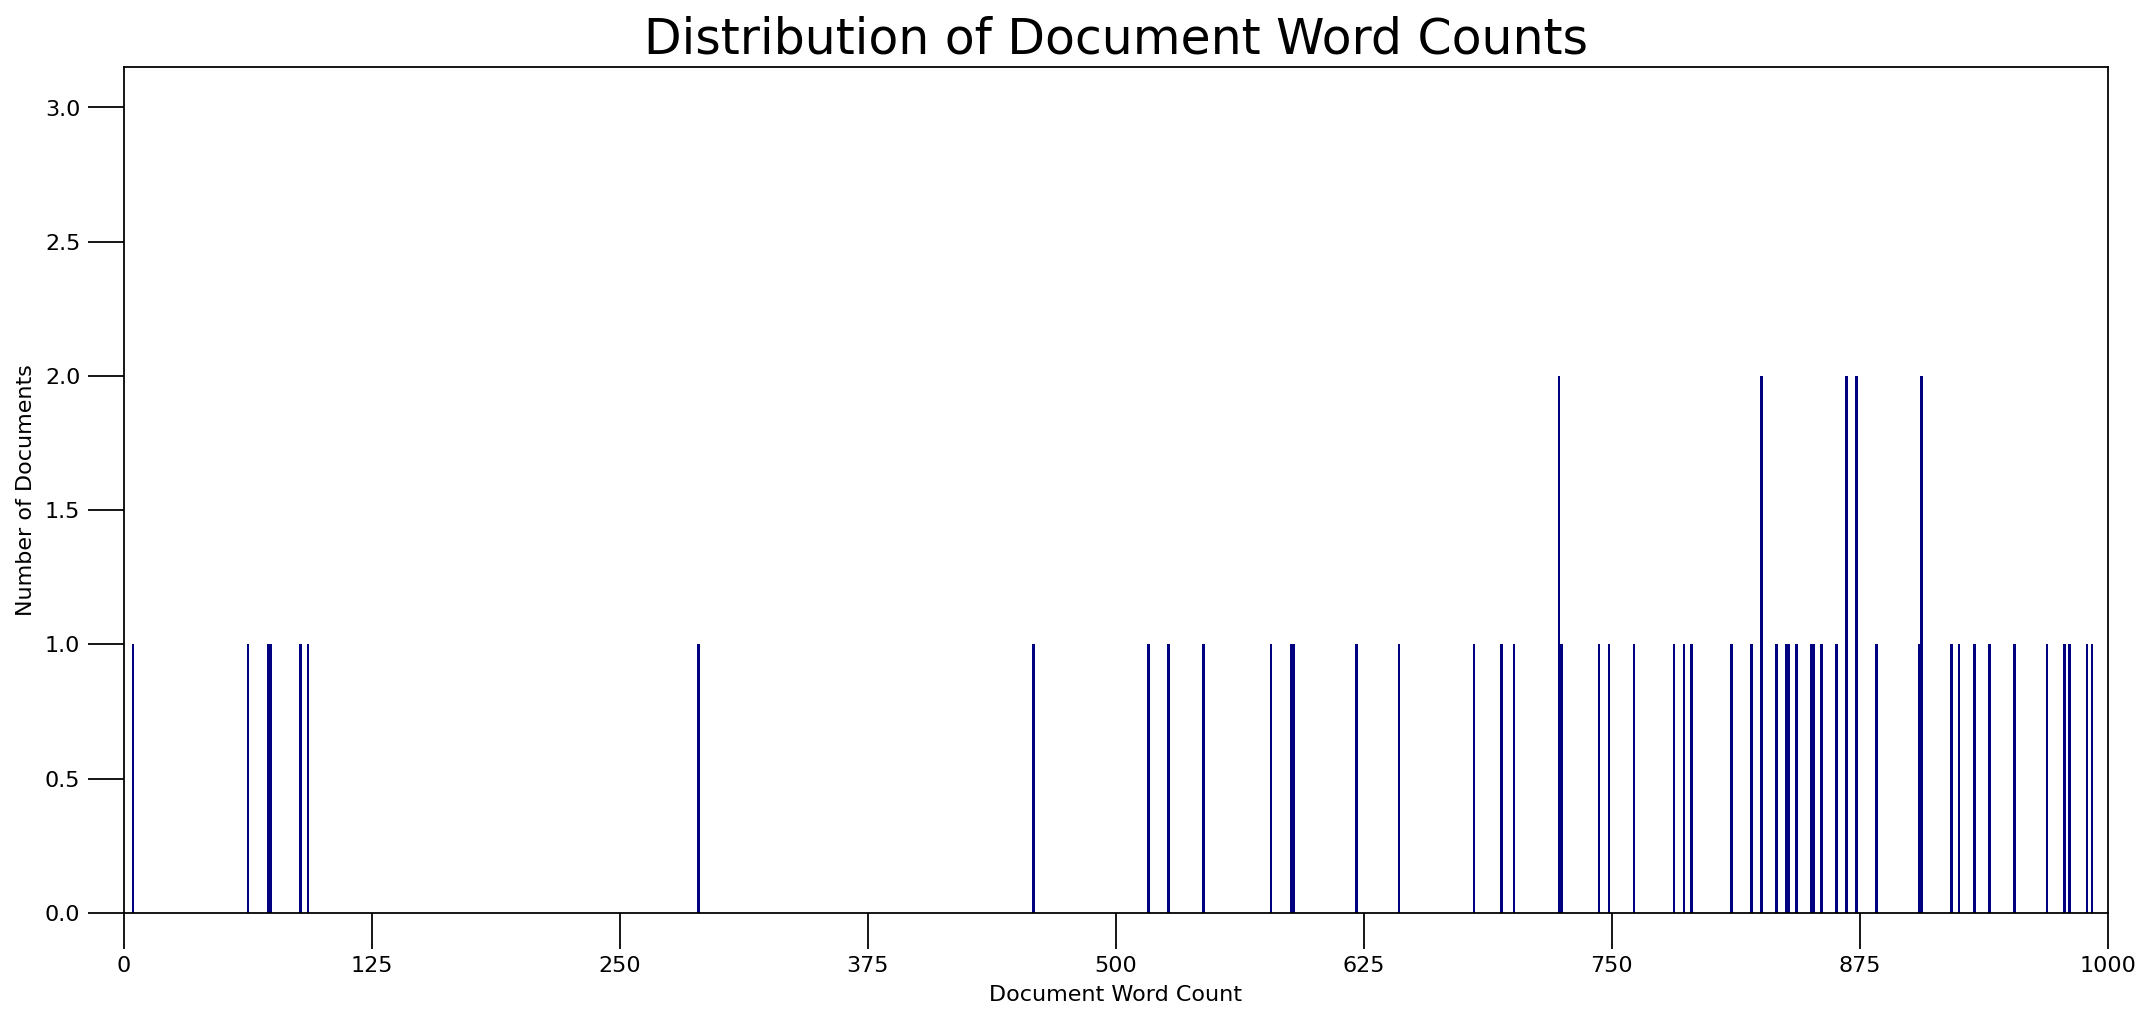

In [24]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [25]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

C:\Users\kantg\.conda\envs\arabic-nlp\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ModuleNotFoundError: No module named 'seaborn'

/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


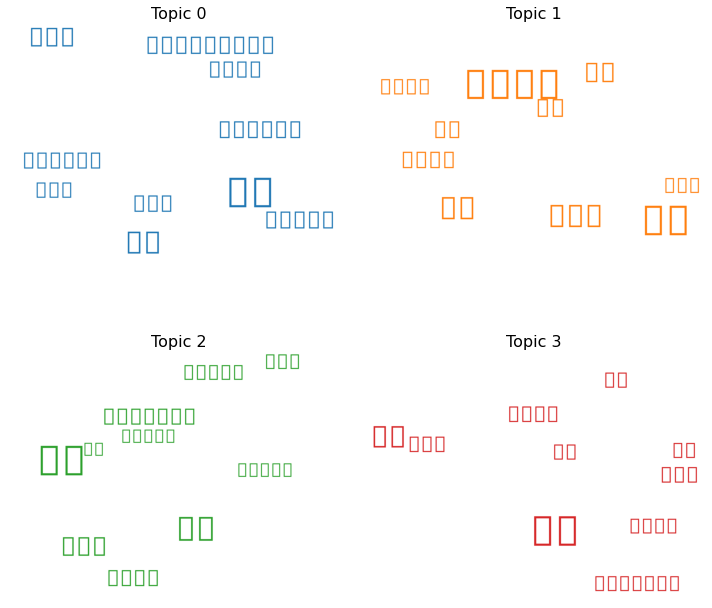

In [67]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-68-3105a4a9aef8>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-68-3105a4a9aef8>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-68-3105a4a9aef8>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-

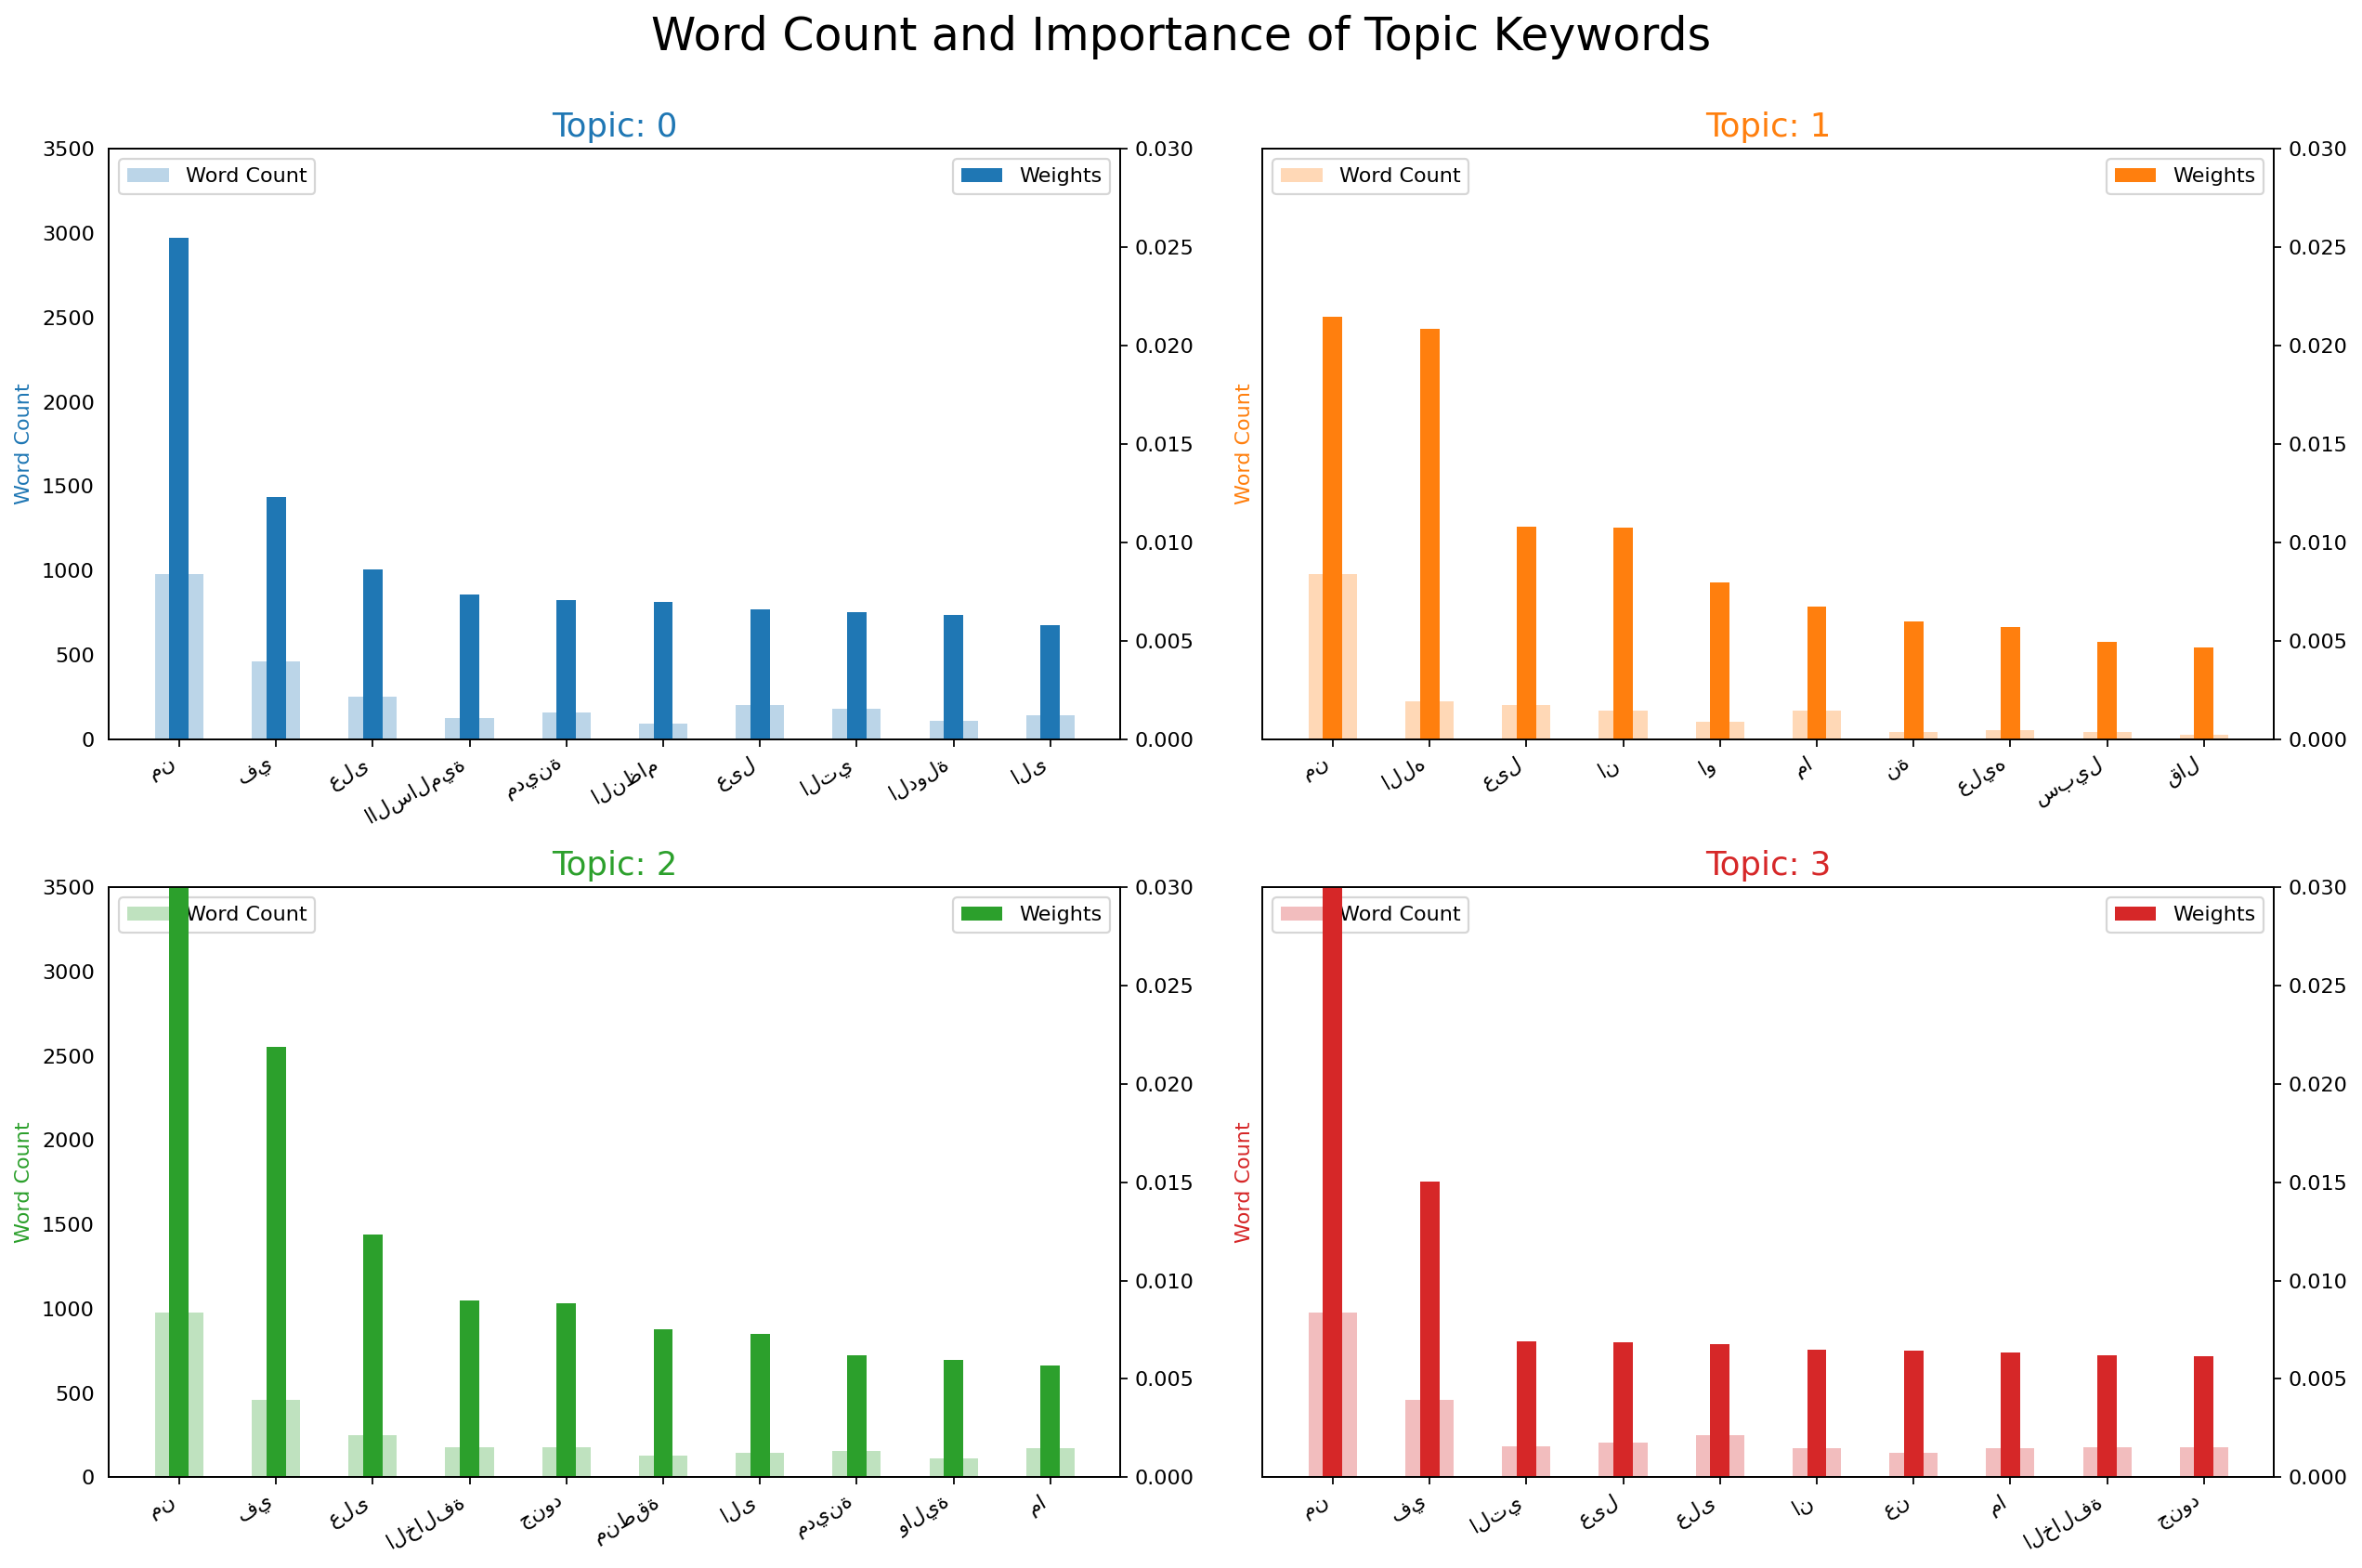

In [68]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


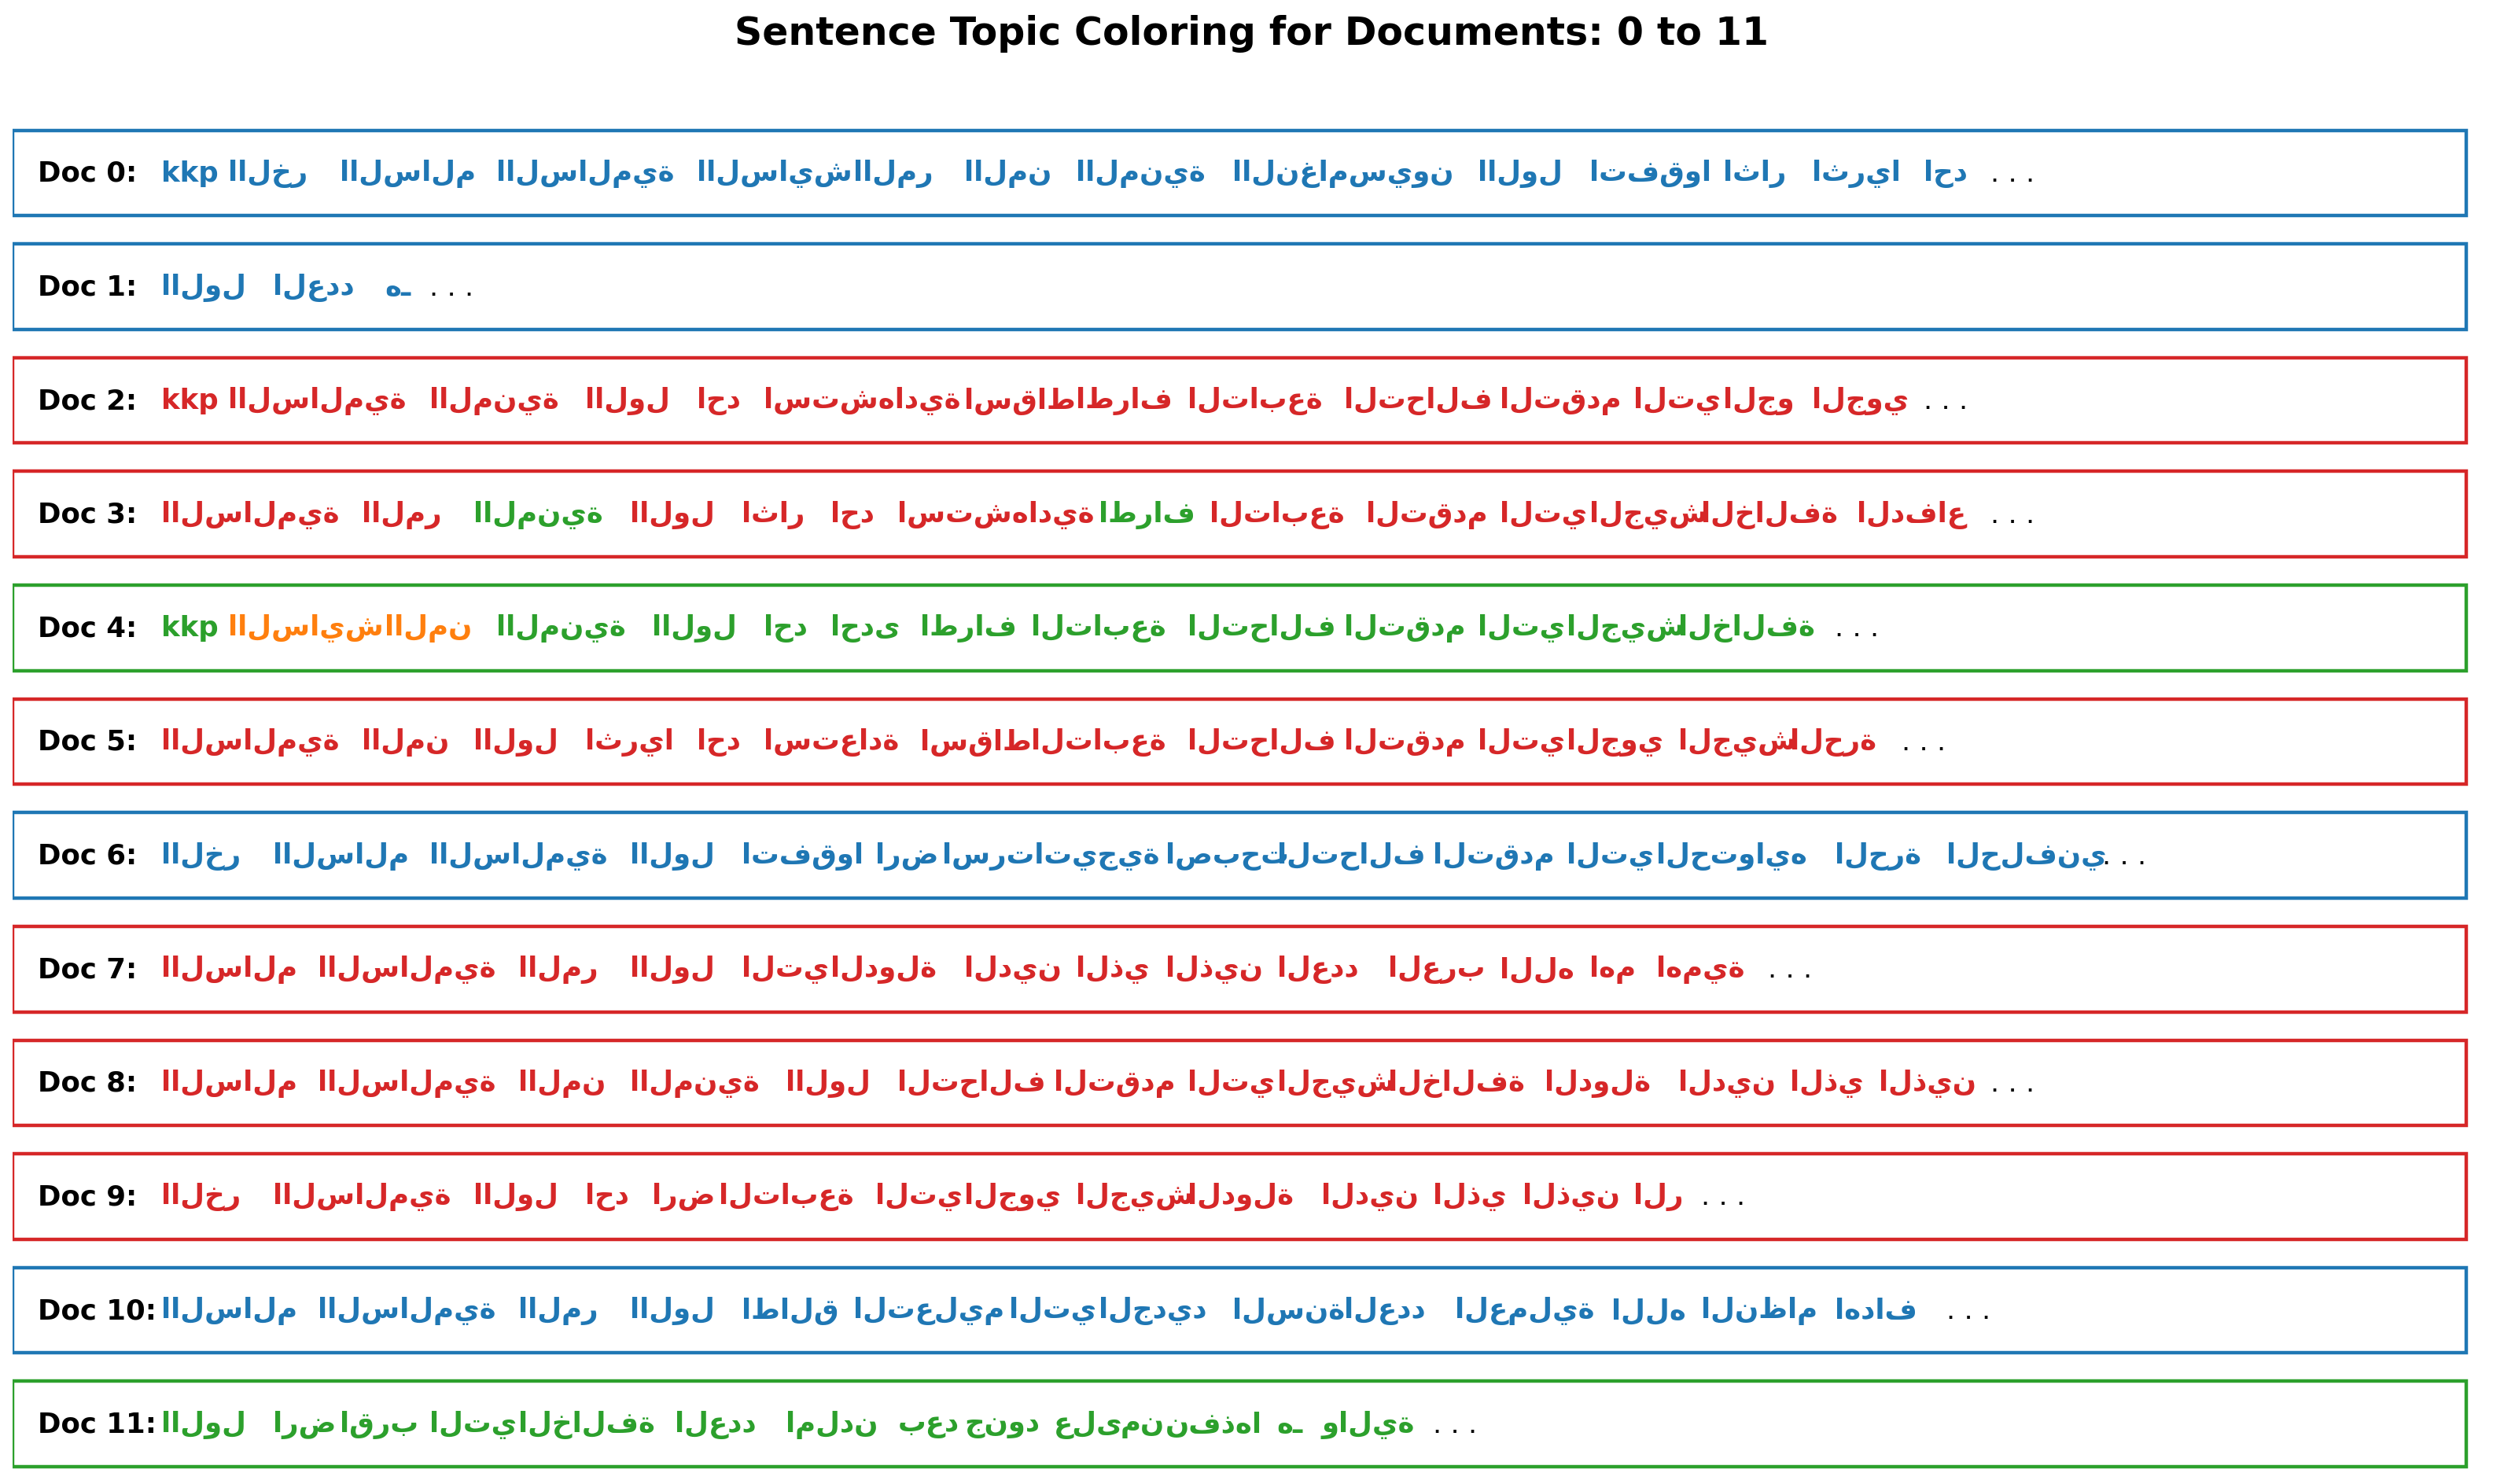

In [69]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()   

In [70]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


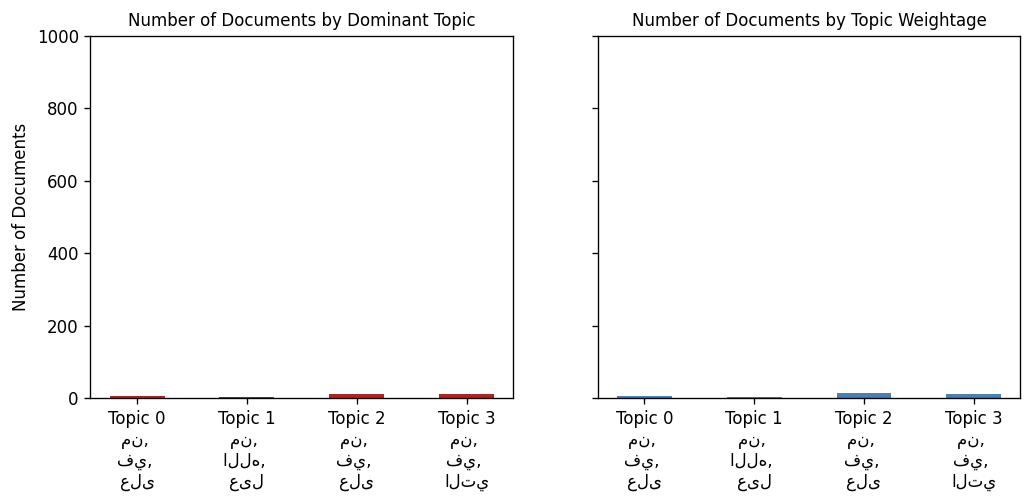

In [71]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [72]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

/home/levin/Python/arabpdf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[t-SNE] Computing 35 nearest neighbors...
[t-SNE] Indexed 36 samples in 0.000s...
[t-SNE] Computed neighbors for 36 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 36 / 36
[t-SNE] Mean sigma: 0.378101
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.217903
[t-SNE] KL divergence after 1000 iterations: 0.456846


Loading BokehJS ...